Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7866 - val_loss: 0.3900
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3607 - val_loss: 0.2781
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2740 - val_loss: 0.2371
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2371 - val_loss: 0.2177
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2213 - val_loss: 0.2070
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2092 - val_loss: 0.1942
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1982 - val_loss: 0.1867
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1842 - val_loss: 0.1695
Epoch 9/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1692 - val_loss: 0.1572
Epoch 10/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1570 - val_loss: 0.1473
Epoch 11/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1470 - val_loss: 0.1420
Epoch 12/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

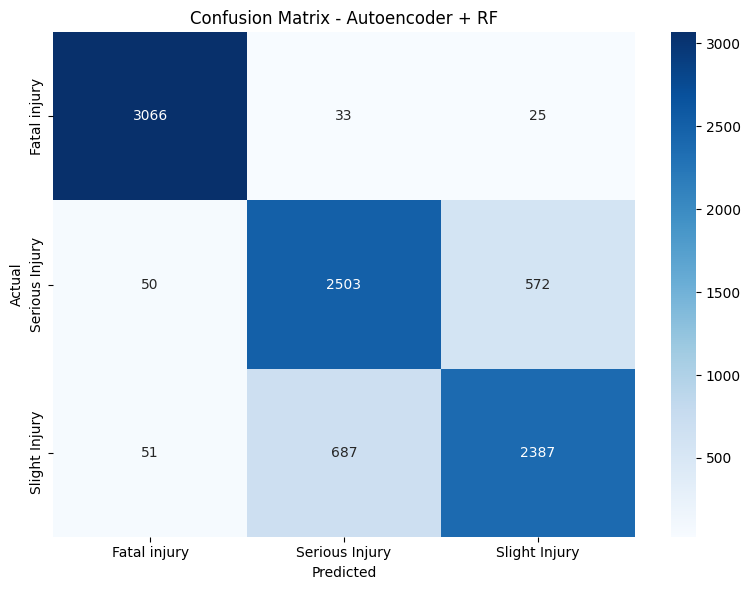

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess dataset
df = pd.read_csv("RTA Dataset.csv")
selected_features = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Cause_of_accident'
]
target = 'Accident_severity'

df = df[selected_features + [target]]
for col in df.columns:
    df[col] = df[col].fillna('Unknown') if df[col].dtype == 'object' else df[col].fillna(df[col].mean())

# Encode categorical variables
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df.drop(target, axis=1)
y = df[target]

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build Autoencoder
input_dim = X_train_scaled.shape[1]
encoding_dim = 16  # Bottleneck size

input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
bottleneck = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train Autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=50, batch_size=64,
                validation_split=0.1, callbacks=[early_stop], verbose=1)

# Extract bottleneck features
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Train RF on encoded features
rf = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced', random_state=42)
rf.fit(X_train_encoded, y_train)
y_pred = rf.predict(X_test_encoded)

# Evaluation
print("\nClassification Report (Autoencoder + RF):")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)
plt.title("Confusion Matrix - Autoencoder + RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Epoch 1/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.7710 - val_loss: 0.4185
Epoch 2/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5824 - val_loss: 0.3673
Epoch 3/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5489 - val_loss: 0.3463
Epoch 4/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5391 - val_loss: 0.3393
Epoch 5/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5234 - val_loss: 0.3238
Epoch 6/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5101 - val_loss: 0.3231
Epoch 7/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5000 - val_loss: 0.3133
Epoch 8/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4958 - val_loss: 0.3202
Epoch 9/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4877 - val_loss: 0.3164
Epoch 10/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4790 - val_loss: 0.3087
Epoch 11/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4822 - val_loss: 0.3105
Epoch 12/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

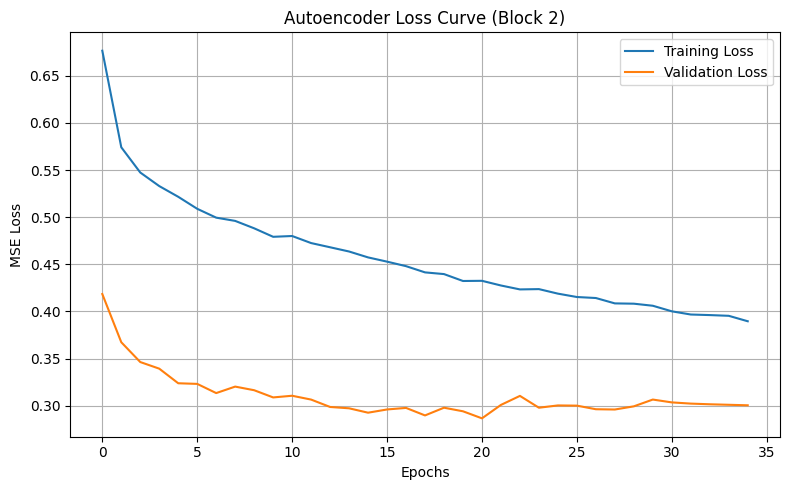

684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

🔹 Block 2 Evaluation
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3124
           1       0.84      0.83      0.83      3125
           2       0.83      0.83      0.83      3125

    accuracy                           0.88      9374
   macro avg       0.88      0.88      0.88      9374
weighted avg       0.88      0.88      0.88      9374



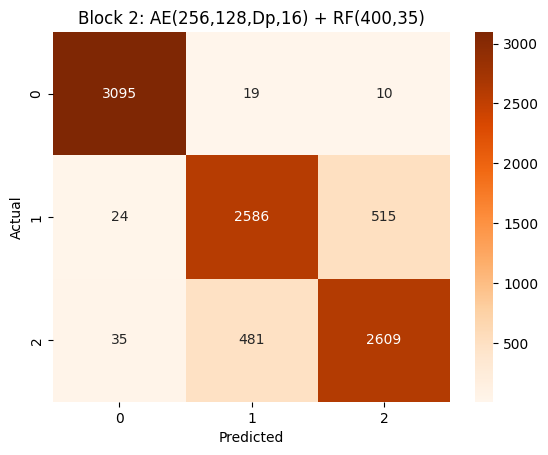

In [13]:
# Block 2 – Autoencoder (256 → 128 → Dropout → 16) + RF (400 trees, depth 35)
from tensorflow.keras.layers import Dropout

input_layer = Input(shape=(X_train_scaled.shape[1],))
x = Dense(256, activation='relu')(input_layer)
x = Dense(128, activation='relu')(x)
bottleneck = Dense(16, activation='relu', name='bottleneck')(x)
x = Dropout(0.3)(bottleneck)
x = Dense(128, activation='relu')(x)
output_layer = Dense(X_train_scaled.shape[1], activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=35,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss Curve (Block 2)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

rf = RandomForestClassifier(n_estimators=400, max_depth=35, class_weight='balanced', random_state=42)
rf.fit(X_train_encoded, y_train)
y_pred = rf.predict(X_test_encoded)

print("\n🔹 Block 2 Evaluation")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Block 2: AE(256,128,Dp,16) + RF(400,35)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss Curve (Block 2)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


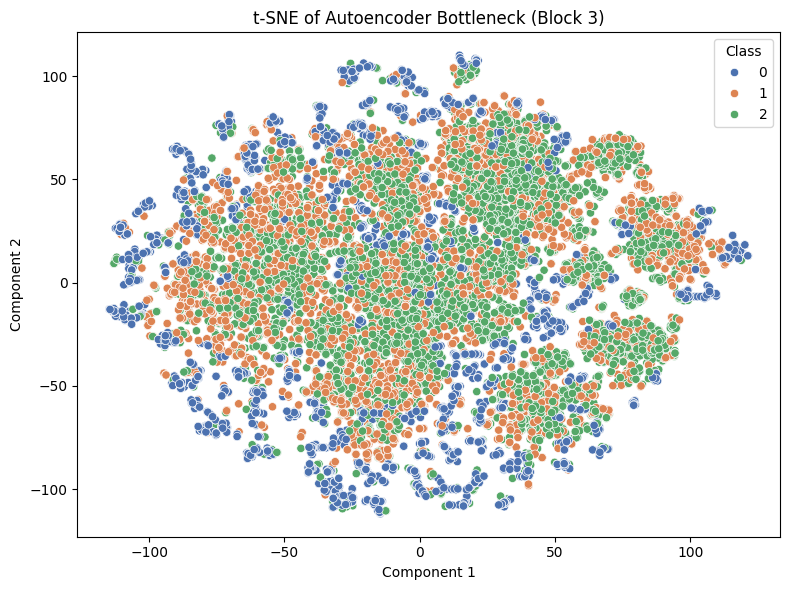

In [10]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# X_train_encoded = output from encoder.predict(...)
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train_encoded)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_train, palette='deep')
plt.title("t-SNE of Autoencoder Bottleneck (Block 3)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5753 - val_loss: 0.0511
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0321 - val_loss: 0.0151
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.0100
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 7/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 8/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 9/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 10/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 11/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 12/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

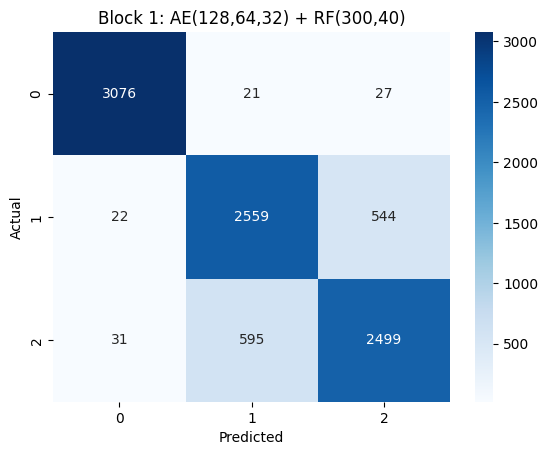

In [5]:
# Block 1 – Autoencoder (128 → 64 → 32) + RF (300 trees, depth 40)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Autoencoder architecture
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
bottleneck = Dense(32, activation='relu', name='bottleneck')(x)
x = Dense(64, activation='relu')(bottleneck)
output_layer = Dense(X_train_scaled.shape[1], activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=30, batch_size=64, validation_split=0.1, verbose=1)

# Feature extraction
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Train RF
rf = RandomForestClassifier(n_estimators=300, max_depth=40, class_weight='balanced', random_state=42)
rf.fit(X_train_encoded, y_train)
y_pred = rf.predict(X_test_encoded)

print("\n🔹 Block 1 Evaluation")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Block 1: AE(128,64,32) + RF(300,40)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Epoch 1/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8445 - val_loss: 0.4913
Epoch 2/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4686 - val_loss: 0.4007
Epoch 3/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3914 - val_loss: 0.3667
Epoch 4/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3638 - val_loss: 0.3469
Epoch 5/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3465 - val_loss: 0.3275
Epoch 6/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3309 - val_loss: 0.3149
Epoch 7/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3169 - val_loss: 0.3060
Epoch 8/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3047 - val_loss: 0.2982
Epoch 9/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2962 - val_loss: 0.2846
Epoch 10/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2870 - val_loss: 0.2737
Epoch 11/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2729 - val_loss: 0.2677
Epoch 12/25
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

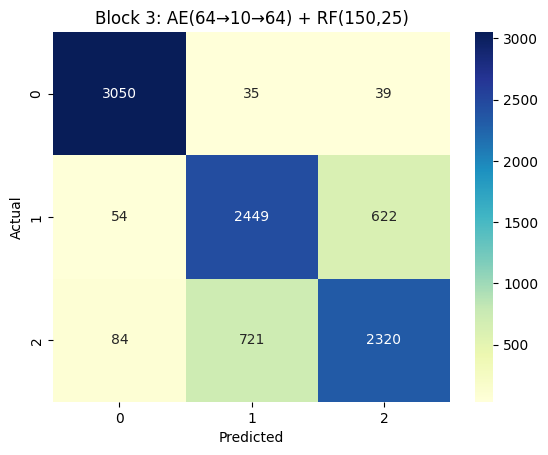

In [7]:
# Block 3 – Autoencoder (64 → 10 → 64) + RF (150 trees, depth 25)
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = Dense(64, activation='relu')(input_layer)
bottleneck = Dense(10, activation='relu', name='bottleneck')(x)
x = Dense(64, activation='relu')(bottleneck)
output_layer = Dense(X_train_scaled.shape[1], activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=25, batch_size=64, validation_split=0.1, verbose=1)

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

rf = RandomForestClassifier(n_estimators=150, max_depth=25, class_weight='balanced', random_state=42)
rf.fit(X_train_encoded, y_train)
y_pred = rf.predict(X_test_encoded)

print("\n🔹 Block 3 Evaluation")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Block 3: AE(64→10→64) + RF(150,25)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Epoch 1/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5281 - val_loss: 0.0362
Epoch 2/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0287 - val_loss: 0.0169
Epoch 3/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0147 - val_loss: 0.0109
Epoch 4/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 5/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 6/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 7/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 8/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 9/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 10/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 11/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 12/35
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

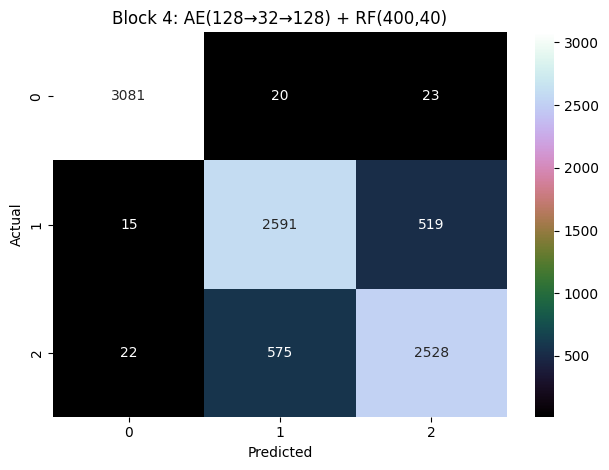

In [8]:
# Block 4 – Autoencoder (128 → 32 → 128) + RF (400 trees, depth 40)
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = Dense(128, activation='relu')(input_layer)
bottleneck = Dense(32, activation='relu', name='bottleneck')(x)
x = Dense(128, activation='relu')(bottleneck)
output_layer = Dense(X_train_scaled.shape[1], activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=35, batch_size=64, validation_split=0.1, verbose=1)

# Feature extraction
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=400, max_depth=40, class_weight='balanced', random_state=42)
rf.fit(X_train_encoded, y_train)
y_pred = rf.predict(X_test_encoded)

# Evaluation
print("\n🔹 Block 4 Evaluation (Compact AE + Strong RF)")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='cubehelix')
plt.title("Block 4: AE(128→32→128) + RF(400,40)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Epoch 1/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.3968 - val_loss: 0.0210
Epoch 2/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0167 - val_loss: 0.0112
Epoch 3/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 4/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 5/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 6/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 8/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 9/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 10/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 11/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/40
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

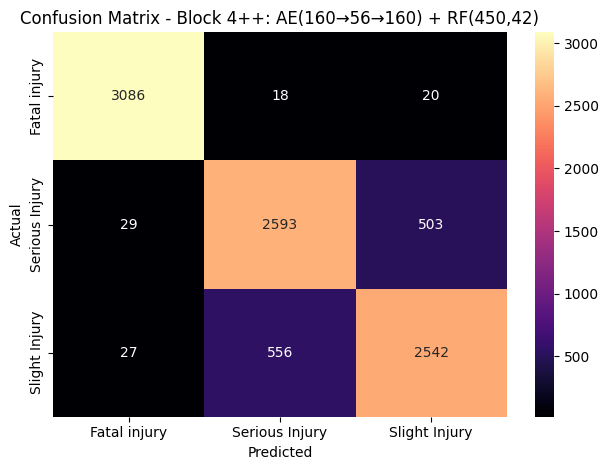

In [9]:
# Block 4++ – AE (160 → 56 → 160) + RF (450 trees, depth 42)
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = Dense(160, activation='relu')(input_layer)
bottleneck = Dense(56, activation='relu', name='bottleneck')(x)
x = Dense(160, activation='relu')(bottleneck)
output_layer = Dense(X_train_scaled.shape[1], activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=40, batch_size=64, validation_split=0.1, verbose=1)

# Extract bottleneck features
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=450, max_depth=42, class_weight='balanced', random_state=42)
rf.fit(X_train_encoded, y_train)
y_pred = rf.predict(X_test_encoded)

# Evaluation
print("\n🔹 Block 4++ Evaluation (Same Layers, Better Nodes + RF)")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)
plt.title("Confusion Matrix - Block 4++: AE(160→56→160) + RF(450,42)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


ValueError: Unrecognized data type: x=Ellipsis (of type <class 'ellipsis'>)